In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
import plotly.io as pio

# Set default renderer for Plotly
# pio.renderers.default = 'notebook'  # Use 'notebook' for Kaggle notebooks
pio.renderers.default = 'iframe'

In [4]:
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
holidays = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

# Objective: 
**Predict sales for each store and product family in the test timeseries**

**EDA** <br>
Question: Is there anything wrong with me using 'dcoilwtico_interpolate' for my predictions? Anything to be worries about?

In [5]:
sales_ts = train[['date', 'sales']].groupby("date").sum().sales
sales_ts

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print(f"{oil.isna()['dcoilwtico'].sum()} Missing Values in dcoilwtico")
oil['dcoilwtico_interpolate'] = oil.interpolate(method='linear')['dcoilwtico']
display(oil.head())
display(pd.DataFrame(sales_ts))

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add the first line trace for `dcoilwtico_interpolate` on the primary y-axis
fig.add_trace(
    go.Scatter(x=oil['date'], y=oil['dcoilwtico_interpolate'], mode='lines', name='Oil Prices'),
    secondary_y=False
)

# Add the second line trace for `sales_ts` on the secondary y-axis
fig.add_trace(
    go.Scatter(x=sales_ts.index, y=sales_ts, mode='lines', name='Sales'),
    secondary_y=True
)

# Update layout and axis titles
fig.update_layout(
    title="Oil Prices and Sales Over Time",
    xaxis_title="Date"
)

# Set y-axis titles
fig.update_yaxes(title_text="Oil Price", secondary_y=False)
fig.update_yaxes(title_text="Sales", secondary_y=True)

# Show the figure
fig.show()

43 Missing Values in dcoilwtico


/tmp/ipykernel_30/2290193114.py:5: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



,date,dcoilwtico,dcoilwtico_interpolate
0,2013-01-01,NaN,NaN
1,2013-01-02,93.14,93.14
2,2013-01-03,92.97,92.97
3,2013-01-04,93.12,93.12
4,2013-01-07,93.20,93.20


,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


**Analysis**
* **Trends:** There is a downward trend in oil prices over time.
* **Seasonality:** Appears to be no seasonal trend.
    * Might have to look at different granularity
* **Cycles:** oil price appears to change in cycles. Rises and falls are not of fixed frequency.
* **Colinearity:** Unfortunately, we didn't find any colinearity between Oil Prices and Sales.

**Analysis**
* **Trends:** There is an **upward trend** in sales over time.
* **Seasonality:** Appears to be a **definite seasonality**. 
* **Cycles:** Do not appear to be cycles.

* **Residuals**: Non-random residuals --> monthly seasonality and trend do not account for some variability

Removing monthly trend and seasonality, we get the following STL decomposition.

In [7]:
sales_ts

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [8]:
from statsmodels.tsa.seasonal import STL

data = sales_ts.copy()
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data = data.resample('ME').mean().ffill()


res = STL(data).fit()

# Plot STL decomposition
fig = make_subplots(
    rows=4, cols=1,
    vertical_spacing=0.03,  
    horizontal_spacing=0.05)
    
fig.add_trace(go.Scatter(x=data.index, y=data, mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=res.trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=res.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=res.resid, mode='markers', name='Residual'), row=4, col=1)

fig.update_layout(title='STL Detrended-Deseasonalized')
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.add_hline(y=0, line_dash="dot", row=4, col="all")


fig.show()

In [9]:
# Retrieve trend, seasonal, and residual components
trend = res.trend
seasonal = res.seasonal
residual = res.resid

detrended_deseasonalized = data - res.trend - res.seasonal

res = STL(detrended_deseasonalized).fit()

# Plot STL decomposition
fig = make_subplots(
    rows=4, cols=1,
    vertical_spacing=0.03,  
    horizontal_spacing=0.05)
    
fig.add_trace(go.Scatter(x=data.index, y=detrended_deseasonalized, mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=res.trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=res.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=res.resid, mode='markers', name='Residual'), row=4, col=1)

fig.update_layout(title='STL Detrended-Deseasonalized')
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.add_hline(y=0, line_dash="dot", row=4, col="all")


fig.show()

**We are looking at granularity on a month to month basis with the plot above. Therfore, we will fail to capture variability at a more granular level (such as weekly basis)**

Observe that there are trends and seasonality that weren't accounted for by our monthly decomposition. Let's take a closer look into the seasonality of our data.

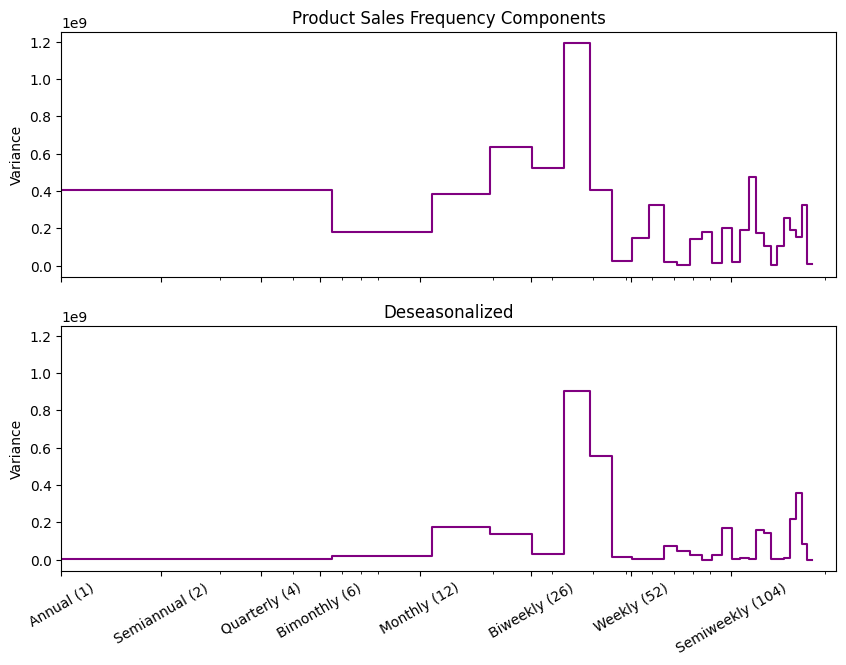

In [10]:
from learntools.time_series.utils import plot_periodogram, seasonal_plot

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(data, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(detrended_deseasonalized, ax=ax2);
ax2.set_title("Deseasonalized");
# ax3 = plot_periodogram(y_deseasoned, ax=ax3);
# ax3.set_title("Deseasonalized");


It appears that we removed most of the variance explained by granularity of less than 1 month, but we still need to account for variance explained by granularity of more than 1 month. HOWEVER... WE ARE USING A DATASET WHERE THE GRANULARITY IS 1 MONTH, SO WE CAN'T ACCOUNT FOR GRANULARITY OF MORE THAN 1 MONTH (IE 1 WEEK)

Create Fourier features to model monthly fluctuations. <br>
Try modifying the frequency!

**Analysis**
Fourier features are great for accounting for periodicity. You can see above that we were able to remove much of the seasonality where the granularity if more than semiannually. In fact, I found from experimenting with Fourier features that a yearly Fourier series accounts for very little of the variability in our timeseries. The information we're missing must not be periodic if we are failing to account for it.


In [11]:
display(transactions.isna().sum())
display(transactions.head())
px.line(transactions, x='date', y='transactions', color = 'store_nbr')

date            0
store_nbr       0
transactions    0
dtype: int64

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


**Analysis**
* **Trends:** No trend. Transactions relatively constant over time.
* **Seasonality:** Seems to be some seasonality with transactions being generally higher around the summer.
    * Modify granularity to see if seasonality exists in different intervals. 
* **Cycles:** No obvious cyclic behavior since ups and downs seem to be associated with time
    * Unless I misread cycles as seasons

In [12]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [13]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [14]:
train.groupby(['family', 'date', 'store_nbr']).sales.sum().reset_index()

,family,date,store_nbr,sales
0,AUTOMOTIVE,2013-01-01,1,0.000
1,AUTOMOTIVE,2013-01-01,2,0.000
2,AUTOMOTIVE,2013-01-01,3,0.000
3,AUTOMOTIVE,2013-01-01,4,0.000
4,AUTOMOTIVE,2013-01-01,5,0.000
...,...,...,...,...
3000883,SEAFOOD,2017-08-15,50,15.314
3000884,SEAFOOD,2017-08-15,51,52.876
3000885,SEAFOOD,2017-08-15,52,7.000
3000886,SEAFOOD,2017-08-15,53,5.000


In [15]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [16]:
sales_fam = train.groupby(["family", "date"]).sales.sum().reset_index()
sales_fam = sales_fam.pivot(index='date', columns='family', values='sales')
sales_fam.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.58900,0.0,186.0,143.0,71.09000,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.0,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.31900,0.0,74629.0,23381.0,15754.50000,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.0,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,0.0,18456.48002,0.0,55893.0,18001.0,11172.45500,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.0,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,0.0,16721.96901,0.0,52064.0,18148.0,10143.20900,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.0,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,0.0,22367.76108,0.0,70128.0,23082.0,13734.94501,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.0,0.0,1245.637004


In [17]:
# Assuming train.family and sales_fam are properly defined
num_families = len(train.family.unique())

# Initialize figure with subplots
fig = make_subplots(
    rows=num_families // 3 + 1, cols=3,
    vertical_spacing=0.03,  
    horizontal_spacing=0.05
)

n = 0  # Start from zero
for category in train.family.unique():
    row = n // 3 + 1  # Use integer division for row calculation
    column = n % 3 + 1  # Modulo to calculate column position
    
    # Add trace for each family category
    fig.add_trace(go.Scatter(x=sales_fam.index, y=sales_fam[category], name=category), row=row, col=column)
    
    n += 1

fig.update_layout(
    height=1200,  # Adjust the total height
    width=1200,   # Adjust the total width
    showlegend=True,  # Keep the legend visible
    title_text="Sales by Family Over Time",
)

# Show the figure
fig.show()


**Analysis** <br>
What do the graphs above tell us?
* Note that we are essentially doing a multivariate timeseries forecasting, therefore, we should be using models that works well in this context. I plan to use a tree based model, since trees are great for dealing with multivariate forecasting.

In [18]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


How do I include holidays in my analysis?

In [19]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [20]:
# daily_family = train.groupby(['date', 'family']).sum().sales
# sales_fam = daily_family.reset_index().pivot(index='date', columns='family', values='sales')
# sales_fam.head()

In [21]:
from pandas.plotting import lag_plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Adjust the subplot creation to have 2 columns (one for Lag-1 and one for Lag-7)
fig = make_subplots(
    rows=num_families, cols=2,  # Two plots per family (Lag-1 and Lag-7)
    vertical_spacing=0.01  # Reduced vertical spacing
)

n = 0  # Start from zero
for family in sales_fam.columns:
    # Create lagged versions
    lagged_fam1 = sales_fam[family].shift(1)
    lagged_fam7 = sales_fam[family].shift(7)
    
    # Calculate correlation coefficients for Lag-1 and Lag-7
    corr_lag1 = sales_fam[family].corr(lagged_fam1)
    corr_lag7 = sales_fam[family].corr(lagged_fam7)

    row = n + 1  # Increment row for each family

    # Add scatter for Lag-1 in the first column
    fig.add_trace(
        go.Scatter(x=lagged_fam1, y=sales_fam[family], name=family + " Lag 1", mode='markers', marker=dict(size=2)),
        row=row, col=1  # Add to the first column
    )
    
    # Add scatter for Lag-7 in the second column
    fig.add_trace(
        go.Scatter(x=lagged_fam7, y=sales_fam[family], name=family + " Lag 7", mode='markers', marker=dict(size=2)),
        row=row, col=2  # Add to the second column
    )
    
    # Add correlation annotations
    fig.add_annotation(
        xref="x domain", yref="y domain",
        x=0.05, y=0.95, showarrow=False,
        text=f"Corr: {corr_lag1:.2f}",
        row=row, col=1
    )
    fig.add_annotation(
        xref="x domain", yref="y domain",
        x=0.05, y=0.95, showarrow=False,
        text=f"Corr: {corr_lag7:.2f}",
        row=row, col=2
    )

    n += 1
    
fig.update_layout(
    height=2500,  # Adjust the height based on the number of rows
    width=800,   # Adjust the width
    showlegend=False,  # Hide legend to prevent clutter
    title_text="Sales by Family with Lag-1 and Lag-7"
)

fig.show()


**Analysis** <br>
The plot above shows that the lagged timeseries have a ***roughly linear relationship*** with the no-lag timeseries. Thus, we can effectively explain the relationship between the lagged and no-lag timeseries using ***autocorrelation***, which measures the strength of linear relationships.

In [22]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define lags
lags = range(1, 8)

# Define the grid layout: 11 rows and 3 columns for 33 families
rows = 6
cols = 6

# Create the subplots with specified rows and columns
fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=sales_fam.columns,
    vertical_spacing=0.05,  # Adjust for tighter spacing
    horizontal_spacing=0.05  # Adjust for better horizontal spacing
)

# Loop through each family column in sales_fam and assign to a subplot
for i, family in enumerate(sales_fam.columns):
    # Calculate row and column index for each subplot
    row = (i // cols) + 1
    col = (i % cols) + 1
    
    # Calculate autocorrelation for lags 1 through 7
    autocorr_values = [sales_fam[family].autocorr(lag=lag) for lag in lags]
    
    # Add bars for each lag in the current subplot
    fig.add_trace(
        go.Bar(
            x=np.arange(1,8),
            y=autocorr_values,
            name=f"{family}",
            width=0.3,
            marker=dict(line=dict(width=1)),
            opacity=0.7
        ),
        row=row, col=col
    )
    fig.add_hline(y=0.3, line_width=2, line_dash="dash", line_color="red", row=row, col=col, annotation_text="Corr=0.3")

# Update layout
fig.update_layout(
    title="Autocorrelation by Family for Lags 1 to 7",
    height=1000,  # Adjusted for the grid size
    showlegend=False  # Hide legends to reduce clutter
)

# Update axis labels (shared across all subplots)
fig.update_xaxes(title_text="Lag", row=rows, col=1)
fig.update_yaxes(title_text="Autocorrelation", row=1, col=1)

# Show plot
fig.show()


**Analysis** <br>
    * Note that no products surpass threshold for negative weak correlation <br>
* For many product families, there is a moderate to strong autocorrelation between the default timeseries and the lagged timeseries throughout a week. This tells us that using lagged timeries as features could help explain some of the weekly variance in products.
* Note: using lagged timeseries will introduce multicollinearity. Determine whether that is okay or if I should lean out the lag features to reduce multicollinearity.

**Create the Model** <br>
1. Create and evaluate a base model
2. Create an evaluate a simple model
3. Conduct feature engineering --> Create a more sophisticated model

**Create a Basic Model**

In [23]:
len(test.date.unique())

16

Note that the forecast horizon is 16 days.

In [24]:
a = pd.get_dummies(train, columns = ['family'], prefix='fam', dtype=float, drop_first=True)
a['date'] = pd.to_datetime(a['date'], format='%Y-%m-%d')

a['day'] = a['date'].dt.day
a['month'] = a['date'].dt.month
a['year'] = a['date'].dt.year
a['day_of_week'] = a['date'].dt.dayofweek
a.drop('date', axis=1, inplace = True)

In [25]:
# One Hot Encode non-Ordinal Categorical Data
a = pd.get_dummies(a, columns = ['day'], prefix='day', dtype=float, drop_first=True)
a = pd.get_dummies(a, columns = ['month'], prefix='month', dtype=float, drop_first=True)
a = pd.get_dummies(a, columns = ['year'], prefix='year', dtype=float, drop_first=True)
a = pd.get_dummies(a, columns = ['day_of_week'], prefix='dow', dtype=float, drop_first=True)

In [26]:
a

,id,store_nbr,sales,onpromotion,fam_BABY CARE,fam_BEAUTY,fam_BEVERAGES,fam_BOOKS,fam_BREAD/BAKERY,fam_CELEBRATION,...,year_2014,year_2015,year_2016,year_2017,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,0,1,0.000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.000,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0.000,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0.000,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,9,438.133,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3000884,3000884,9,154.553,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3000885,3000885,9,2419.729,148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3000886,3000886,9,121.000,8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


Should I have One-Hot Encoded values I'm grouping by? ie family?

In [27]:
split_point = int(np.round(a.shape[0] * 0.8))
a_train = a.iloc[:split_point]
a_val = a.iloc[split_point:]
print("Train Shape", a_train.shape)
print("Validation Shape", a_val.shape)

Train Shape (2400710, 87)
Validation Shape (600178, 87)


**Create a Simple Model**

In [28]:
X_train = a_train.drop("sales", axis=1)
y_train = a_train.sales

X_val = a_val.drop("sales", axis=1)
y_val = a_val.sales

In [29]:
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_estimators=20, random_state=0)
# model.fit(X_train, y_train)

In [30]:
# y_pred = pd.Series(model.predict(X_val))

In [31]:
# y_pred

In [32]:
# from sklearn.metrics import mean_squared_log_error

# mean_squared_log_error(y_val, y_pred)

A good forecasting method will yield innovation residuals with the following properties:

The innovation residuals are uncorrelated. If there are correlations between innovation residuals, then there is information left in the residuals which should be used in computing forecasts.
The innovation residuals have zero mean. If they have a mean other than zero, then the forecasts are biased. https://otexts.com/fpp3/diagnostics.html

**Train a Model Using your EDA Observations**

Lagging like this doesn't make sense since the lag will push the sales from one category to another category. We don't want this. We want lags to become features for the same category

In [33]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

y = sales_ts.copy()
y.index = pd.to_datetime(y.index, format='%Y-%m-%d')
y = y.resample('D').mean().ffill()
y_train = y[:-16]
y_val = y[-16:]

fourierW = CalendarFourier(freq="W", order=4)
fourierM = CalendarFourier(freq="ME", order=4)
fourierY = CalendarFourier(freq="YE", order=4)

dp = DeterministicProcess(
    index=y_train.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourierW, fourierM, fourierY],
    drop=True,
)
X_train = dp.in_sample()

In [34]:
X_train

,const,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","sin(1,freq=ME)","cos(1,freq=ME)",...,"sin(4,freq=ME)","cos(4,freq=ME)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,0.201299,0.979530,...,0.724793,0.688967,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630
2013-01-03,1.0,3.0,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,0.394356,0.918958,...,0.998717,-0.050649,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532
2013-01-04,1.0,4.0,-0.433884,-0.900969,0.781831,0.623490,-0.222521,0.974928,0.571268,0.820763,...,0.651372,-0.758758,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740
2013-01-05,1.0,5.0,-0.974928,-0.222521,0.433884,-0.900969,0.623490,-0.781831,0.724793,0.688967,...,-0.101168,-0.994869,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-26,1.0,1668.0,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,-0.937752,0.347305,...,0.988468,0.151428,-0.393590,-0.919286,0.723644,0.690173,-0.936881,-0.349647,0.998880,-0.047321
2017-07-27,1.0,1669.0,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,-0.848644,0.528964,...,0.790776,-0.612106,-0.409356,-0.912375,0.746972,0.664855,-0.953681,-0.300820,0.993257,-0.115935
2017-07-28,1.0,1670.0,-0.433884,-0.900969,0.781831,0.623490,-0.222521,0.974928,-0.724793,0.688967,...,0.101168,-0.994869,-0.425000,-0.905193,0.769415,0.638749,-0.967938,-0.251190,0.982927,-0.183998


In [35]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = pd.Series(lr.predict(X_train), index=X_train.index, name="Fitted")
y_train_deseasoned = y_train - y_pred

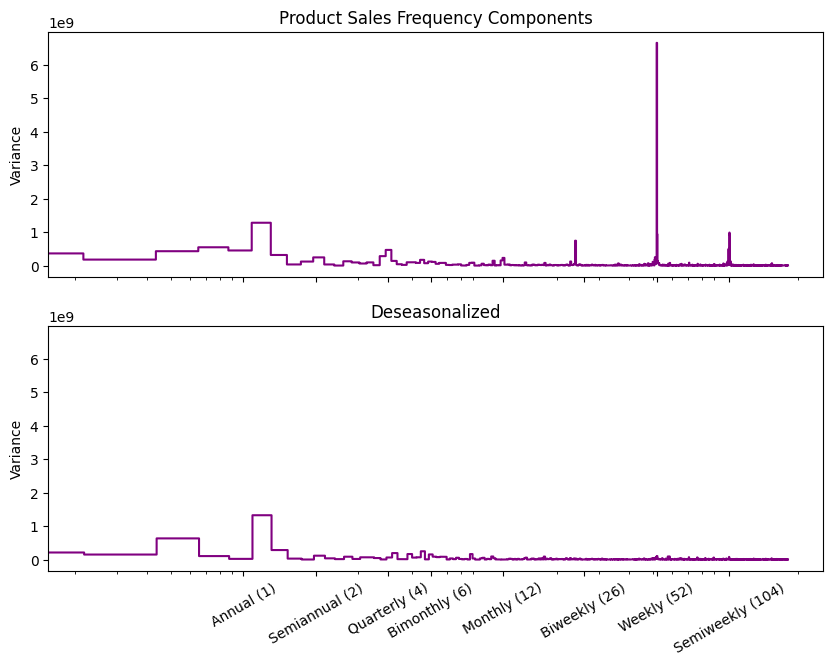

In [36]:
from learntools.time_series.utils import plot_periodogram, seasonal_plot

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(sales_ts, ax=ax1)
ax1.set_title("Product Sales Frequency Components")

ax2 = plot_periodogram(y_train_deseasoned, ax=ax2);
ax2.set_title("Deseasonalized");

**Analysis**
Fourier features are great for accounting for periodicity. You can see above that we were able to remove much of the seasonality where the granularity if more than semiannually. In fact, I found from experimenting with Fourier features that a yearly Fourier series accounts for very little of the variability in our timeseries. The information we're missing must not be periodic if we are failing to account for it.

Let's use our analysis from earlier to add features which can account the missing variance

In [37]:
X_train

,const,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","sin(1,freq=ME)","cos(1,freq=ME)",...,"sin(4,freq=ME)","cos(4,freq=ME)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,0.201299,0.979530,...,0.724793,0.688967,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630
2013-01-03,1.0,3.0,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,0.394356,0.918958,...,0.998717,-0.050649,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532
2013-01-04,1.0,4.0,-0.433884,-0.900969,0.781831,0.623490,-0.222521,0.974928,0.571268,0.820763,...,0.651372,-0.758758,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740
2013-01-05,1.0,5.0,-0.974928,-0.222521,0.433884,-0.900969,0.623490,-0.781831,0.724793,0.688967,...,-0.101168,-0.994869,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-26,1.0,1668.0,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,-0.937752,0.347305,...,0.988468,0.151428,-0.393590,-0.919286,0.723644,0.690173,-0.936881,-0.349647,0.998880,-0.047321
2017-07-27,1.0,1669.0,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,-0.848644,0.528964,...,0.790776,-0.612106,-0.409356,-0.912375,0.746972,0.664855,-0.953681,-0.300820,0.993257,-0.115935
2017-07-28,1.0,1670.0,-0.433884,-0.900969,0.781831,0.623490,-0.222521,0.974928,-0.724793,0.688967,...,0.101168,-0.994869,-0.425000,-0.905193,0.769415,0.638749,-0.967938,-0.251190,0.982927,-0.183998


In [38]:
X_train

,const,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","sin(1,freq=ME)","cos(1,freq=ME)",...,"sin(4,freq=ME)","cos(4,freq=ME)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,0.201299,0.979530,...,0.724793,0.688967,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630
2013-01-03,1.0,3.0,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,0.394356,0.918958,...,0.998717,-0.050649,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532
2013-01-04,1.0,4.0,-0.433884,-0.900969,0.781831,0.623490,-0.222521,0.974928,0.571268,0.820763,...,0.651372,-0.758758,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740
2013-01-05,1.0,5.0,-0.974928,-0.222521,0.433884,-0.900969,0.623490,-0.781831,0.724793,0.688967,...,-0.101168,-0.994869,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-26,1.0,1668.0,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,-0.937752,0.347305,...,0.988468,0.151428,-0.393590,-0.919286,0.723644,0.690173,-0.936881,-0.349647,0.998880,-0.047321
2017-07-27,1.0,1669.0,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,-0.848644,0.528964,...,0.790776,-0.612106,-0.409356,-0.912375,0.746972,0.664855,-0.953681,-0.300820,0.993257,-0.115935
2017-07-28,1.0,1670.0,-0.433884,-0.900969,0.781831,0.623490,-0.222521,0.974928,-0.724793,0.688967,...,0.101168,-0.994869,-0.425000,-0.905193,0.769415,0.638749,-0.967938,-0.251190,0.982927,-0.183998


In [39]:
y = pd.DataFrame(train.groupby(["store_nbr", "family", "date"]).sales.sum()).unstack(['store_nbr', 'date'])
y

sales                                       \
store_nbr                          1                                         
date                       2013-01-01 2013-01-02   2013-01-03   2013-01-04   
family                                                                       
AUTOMOTIVE                        0.0      2.000     3.000000     3.000000   
BABY CARE                         0.0      0.000     0.000000     0.000000   
BEAUTY                            0.0      2.000     0.000000     3.000000   
BEVERAGES                         0.0   1091.000   919.000000   953.000000   
BOOKS                             0.0      0.000     0.000000     0.000000   
BREAD/BAKERY                      0.0    470.652   310.655000   198.366000   
CELEBRATION                       0.0      0.000     0.000000     0.000000   
CLEANING                          0.0   1060.000   836.000000   827.000000   
DAIRY                             0.0    579.000   453.000000   460.000000   
DELI                              0.0    164.069   151.582000   131.411000   
EGGS                              0.0    246.000   203.000000   171.000000   
FROZEN FOODS                      0.0    131.000    87.044000    65.000000   
GROCERY I                         0.0   2652.000  2121.000000  2056.000000   
GROCERY II                        0.0     31.000    12.000000    15.000000   
HARDWARE                          0.0      3.000     1.000000     7.000000   
HOME AND KITCHEN I                0.0      0.000     0.000000     0.000000   
HOME AND KITCHEN II               0.0      0.000     0.000000     0.000000   
HOME APPLIANCES                   0.0      0.000     2.000000     0.000000   
HOME CARE                         0.0      0.000     0.000000     0.000000   
LADIESWEAR                        0.0      0.000     0.000000     0.000000   
LAWN AND GARDEN                   0.0     10.000     0.000000     7.000000   
LINGERIE                          0.0     13.000    15.000000    24.000000   
LIQUOR,WINE,BEER                  0.0     67.000    66.000000   102.000000   
MAGAZINES                         0.0      0.000     0.000000     0.000000   
MEATS                             0.0    369.101   272.319000   454.172000   
PERSONAL CARE                     0.0    194.000   153.000000    88.000000   
PET SUPPLIES                      0.0      0.000     0.000000     0.000000   
PLAYERS AND ELECTRONICS           0.0      0.000     0.000000     0.000000   
POULTRY                           0.0    247.297   187.278000   258.023000   
PREPARED FOODS                    0.0     47.000    63.000000    67.000000   
PRODUCE                           0.0      0.000     0.000000     0.000000   
SCHOOL AND OFFICE SUPPLIES        0.0      0.000     0.000000     0.000000   
SEAFOOD                           0.0     38.029    17.366001    29.907001   

                                                                         \
store_nbr                                                                 
date                        2013-01-05 2013-01-06 2013-01-07 2013-01-08   
family                                                                    
AUTOMOTIVE                     5.00000      2.000      0.000      2.000   
BABY CARE                      0.00000      0.000      0.000      0.000   
BEAUTY                         3.00000      0.000      1.000      3.000   
BEVERAGES                   1160.00000    407.000   1158.000   1029.000   
BOOKS                          0.00000      0.000      0.000      0.000   
BREAD/BAKERY                 301.05700    147.182    309.676    321.851   
CELEBRATION                    0.00000      0.000      0.000      0.000   
CLEANING                     811.00000    257.000    829.000    827.000   
DAIRY                        464.00000    212.000    400.000    384.000   
DELI                         118.61300     60.135    113.235    130.085   
EGGS                         177.00000     85.000    157.000    150.000   
FROZEN FOODS        

In [40]:
# Create y values to train and validate random forest on. Should be of same format as y right above.

pd.to_datetime(train['date'], format="%Y-%m-%-d")



ValueError: '-' is a bad directive in format '%Y-%m-%-d'

In [ ]:
y_train = 

In [ ]:
# X = X[X.index.isin(y.index)]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=5, random_state=0)
model.fit(X_train, y)

In [ ]:
X_val = dp.out_of_sample(steps=16)

In [ ]:
model.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(y_pred, index=X_val.index, columns=y.columns)
y_pred = y_pred.stack(['store_nbr', 'family'])
y_pred

In [ ]:
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(y, y_pred)

In [ ]:
# param_grid = { 
#     'n_estimators': [200, 700],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X, y)
# print CV_rfc.best_params_